# Face Mask Detection using NVIDIA TLT 

The MIT License (MIT)

Copyright (c) 2019-2020, NVIDIA CORPORATION.

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## DetectNet_v2 with ResNet-18 example usecase

The goal of this notebook is to utilize NVIDIA TLT to train and make PPE detection model deploy ready.
While working on such application, this notebook will serve as an example usecase of Object Detection using DetectNet_v2 in the Transfer Learning Toolkit.

0. [Set up env variables](#head-0)
1. [Prepare dataset and pre-trained model](#head-1)
    1. [Download dataset](#head-1-1)
    1. [Prepare tfrecords from kitti format dataset](#head-1-2)
    2. [Download pre-trained model](#head-1-3)
2. [Provide training specification](#head-2)
3. [Run TLT training](#head-3)
4. [Evaluate trained models](#head-4)
5. [Prune trained models](#head-5)
6. [Retrain pruned models](#head-6)
7. [Evaluate retrained model](#head-7)
8. [Visualize inferences](#head-8)
9. [Deploy](#head-9)
    1. [Int8 Optimization](#head-9-1)
    2. [Generate TensorRT engine](#head-9-2)
10. [Verify Deployed Model](#head-10)
    1. [Inference using TensorRT engine](#head-10-1)

## 0. Set up env variables <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

In [4]:
# Setting up env variables for cleaner command line commands.
print("Update directory paths if needed")
%env KEY=tlt_encode
# User directory - pre-trained/unpruned/pruned/final models will be saved here
%env USER_EXPERIMENT_DIR=helmet/detectnet_v2
# Download directory - tfrecords will be generated here
%env DATA_DOWNLOAD_DIR=helmet/data_fm_0916         
# Spec Directory
%env SPECS_DIR=helmet/detectnet_v2/tlt_specs  
# Number of GPUs used for training
%env NUM_GPUS=1

Update directory paths if needed
env: KEY=tlt_encode
env: USER_EXPERIMENT_DIR=helmet/detectnet_v2
env: DATA_DOWNLOAD_DIR=helmet/data_fm_0916
env: SPECS_DIR=helmet/detectnet_v2/tlt_specs
env: NUM_GPUS=1


## 1. Prepare dataset and pre-trained model <a class="anchor" id="head-1"></a>

### A. Download dataset  <a class="anchor" id="head-1-1"></a>

Images and Labels folder in the repository


- Download the data using provided links, such that all images and label files are in one folder. We expect in structure noted in GitHub repo.
- Convert dataset to KITTI format 
- Use KITTI format directory as "$DATA_DOWNLOAD_DIR"


Note: We do not use all the images from MAFA and WiderFace. Combining we will use about 6000 faces each with and without mask

### B. Prepare tf records from kitti format dataset <a class="anchor" id="head-1-2"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the tlt-dataset-convert 

*Note: TfRecords only need to be generated once.*

In [3]:
print("TFrecords conversion spec file for kitti training")
!cat $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for kitti training
kitti_config {
  root_directory_path: "/workspace/mntpt/helmet"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 20
  num_shards: 10 }


In [21]:
# Creating a new directory for the output tfrecords dump.
print("Converting Tfrecords for kitti trainval dataset")
!tlt-dataset-convert -d $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/kitti_trainval

Converting Tfrecords for kitti trainval dataset
2021-06-20 06:27:35.583485: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2021-06-20 06:27:37,364 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-06-20 06:27:37,367 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 988	Val: 247
2021-06-20 06:27:37,367 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2021-06-20 06:27:37,368 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2021-06-20 06:27:37,368 - tensorflow - WARNING - From /home/vpraveen/.cache/dazel/_dazel_vpraveen/715c8bafe7816f3bb6f309cd506049bb/execroot/ai_infra/bazel-out/k8-py3-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/dataio/da

In [22]:
!ls -rlt $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/

total 932
-rwxrwxrwx 1 1000 1000 17661 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rwxrwxrwx 1 1000 1000 18754 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rwxrwxrwx 1 1000 1000 17129 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rwxrwxrwx 1 1000 1000 16396 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rwxrwxrwx 1 1000 1000 18345 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rwxrwxrwx 1 1000 1000 18955 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rwxrwxrwx 1 1000 1000 19038 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rwxrwxrwx 1 1000 1000 17079 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rwxrwxrwx 1 1000 1000 17651 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rwxrwxrwx 1 1000 1000 23797 Jun 20 06:27 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rwxrwxrwx 1 1000 1000 74715 Jun 20 06:27 kitti_tr

### C. Download pre-trained model <a class="anchor" id="head-1-3"></a>
Download the correct pretrained model from the NGC model registry for your experiment. Please note that for DetectNet_v2, the input is expected to be 0-1 normalized with input channels in RGB order. Therefore, for optimum results please download models with `*_detectnet_v2` in their name string. All other models expect input preprocessing with mean subtraction and input channels in BGR order. Thus, using them as pretrained weights may result in suboptimal performance. 

In [6]:
# List models available in the model registry.
!ngc registry model list nvidia/tlt_pretrained_detectnet_v2:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 82.6  | 80    | 1     | V100  | 153.8 | 153.7 | UPLOA | Apr   |
|       |       |       |       |       |       | 7 MB  | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| vgg16 | 82.2  | 80    | 1     | V100  | 113.2 | 113.2 | UPLOA | Apr   |
|       |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| squee | 65.67 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Apr   |
| zenet |       |       |       |     

In [7]:
# Create the target destination to download the model.
!mkdir -p $USER_EXPERIMENT_DIR/pretrained_resnet18/

In [8]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_detectnet_v2:resnet18 \
    --dest $USER_EXPERIMENT_DIR/pretrained_resnet18

Downloaded 82.28 MB in 20s, Download speed: 4.11 MB/s               
----------------------------------------------------
Transfer id: tlt_pretrained_detectnet_v2_vresnet18 Download status: Completed.
Downloaded local path: /workspace/mntpt/home/detectnet_v2/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18
Total files downloaded: 1 
Total downloaded size: 82.28 MB
Started at: 2021-06-14 07:19:33.280954
Completed at: 2021-06-14 07:19:53.305744
Duration taken: 20s
----------------------------------------------------


In [9]:
!ls -rlt $USER_EXPERIMENT_DIR/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18

total 91160
-rwxrwxrwx 1 1000 1000 93345248 Jun 14 07:19 resnet18.hdf5


## 2. Provide training specification <a class="anchor" id="head-2"></a>
* Tfrecords for the train datasets
    * In order to use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold `0` only
    * For sequence-wise split, you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [23]:
!cat $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/mntpt/helmet/data_fm_0916/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/mntpt/helmet"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "helmet"
    value: "helmet"
  }
  target_class_mapping {
    key: "person_with_helmet"
    value: "person_with_helmet"
  }
  target_class_mapping {
    key: "person_without_helmet"
    value: "person_without_helmet"
  }
  validation_fold: 0
  #validation_data_source: {
    #tfrecords_path: "/home/data/tfrecords/kitti_val/*"
    #image_directory_path: "/home/data/test"
  #}
}


augmentation_config {
  preprocessing {
    output_image_width: 960
    output_image_height: 544
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    vflip_probability: 0.0
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation 

## 3. Run TLT training <a class="anchor" id="head-3"></a>
* Provide the sample spec file and the output directory location for models

*Note: The training may take hours to complete. Also, the remaining notebook, assumes that the training was done in single-GPU mode. When run in multi-GPU mode, please expect to update the pruning and inference steps with new pruning thresholds and updated parameters in the clusterfile.json accordingly for optimum performance.*

*Detectnet_v2 now supports restart from checkpoint. Incase, the training job is killed prematurely, you may resume training from the closest checkpoint by simply re-running the same command line. Please do make sure to use the same number of GPUs when restarting the training.*

In [6]:
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
                        -k $KEY \
                        -n resnet18_detector_hemlet \
                        --gpus $NUM_GPUS

Using TensorFlow backend.
2021-06-20 06:45:59.904556: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 06:46:01.914699: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-06-20 06:46:01.944404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 06:46:01.944796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 06:46:01.944814: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 06:46:01.944845: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully o

2021-06-20 06:46:08,982 [INFO] iva.detectnet_v2.dataloader.default_dataloader: Bounding box coordinates were detected in the input specification! Bboxes will be automatically converted to polygon coordinates.
2021-06-20 06:46:09.005344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 06:46:09.005728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 06:46:09.005749: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 06:46:09.005774: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-06-20 06:46:09.005793: I tensorflow/stream_executor/platfor

2021-06-20 06:46:41.309419: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-06-20 06:46:41.309473: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-06-20 06:46:41.455023: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-06-20 06:46:41.455066: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Alloc

2021-06-20 06:53:44,117 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.830
2021-06-20 06:53:54,403 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 34.027
2021-06-20 06:53:57,351 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 11/200: loss: 0.00104 Time taken: 0:00:29.350635 ETA: 1:32:27.270070
2021-06-20 06:54:04,834 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.557
2021-06-20 06:54:15,271 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.536
2021-06-20 06:54:25,781 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.301
2021-06-20 06:54:27,045 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 12/200: loss: 0.00092 Time taken: 0:00:29.697202 ETA: 1:33:03.073970
2021-06-20 06:54:36,377 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.032
2021-06-20 06:54:47,295 [INFO] modulus.hooks.sample_co

2021-06-20 07:03:26,915 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.282
2021-06-20 07:03:34,490 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 27/200: loss: 0.00068 Time taken: 0:00:29.885461 ETA: 1:26:10.184728
2021-06-20 07:03:37,428 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.293
2021-06-20 07:03:47,921 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.357
2021-06-20 07:03:58,733 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.374
2021-06-20 07:04:04,615 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 28/200: loss: 0.00074 Time taken: 0:00:30.110404 ETA: 1:26:18.989532
2021-06-20 07:04:09,226 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.355
2021-06-20 07:04:19,742 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.284
2021-06-20 07:04:30,218 [INFO] modulus.hooks.sample_co

2021-06-20 07:12:19,972 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 41/200: loss: 0.00081 Time taken: 0:00:29.956698 ETA: 1:19:23.115010
2021-06-20 07:12:25,516 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.127
2021-06-20 07:12:36,027 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.299
2021-06-20 07:12:46,608 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.079
2021-06-20 07:12:50,005 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 42/200: loss: 0.00073 Time taken: 0:00:30.018724 ETA: 1:19:02.958424
2021-06-20 07:12:57,193 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.065
2021-06-20 07:13:07,702 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.307
2021-06-20 07:13:18,179 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.408
2021-06-20 07:13:19,860 [INFO] /usr/local/lib/python3.

2021-06-20 07:20:53,493 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.298
2021-06-20 07:21:04,051 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.152
2021-06-20 07:21:14,542 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.364
2021-06-20 07:21:22,479 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 58/200: loss: 0.00065 Time taken: 0:00:29.851150 ETA: 1:10:38.863271
2021-06-20 07:21:25,017 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.412
2021-06-20 07:21:35,489 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.423
2021-06-20 07:21:45,991 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.329
2021-06-20 07:21:52,316 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 59/200: loss: 0.00066 Time taken: 0:00:29.822719 ETA: 1:10:05.003426
2021-06-20 07:21:56,536 [INFO] modulus.hooks.sample_co

2021-06-20 07:28:22,281 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.441
2021-06-20 07:28:32,846 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.128
2021-06-20 07:28:38,306 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 72/200: loss: 0.00063 Time taken: 0:00:29.871326 ETA: 1:03:43.529785
2021-06-20 07:28:43,388 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.199
2021-06-20 07:28:53,922 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.227
2021-06-20 07:29:04,402 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.398
2021-06-20 07:29:08,177 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 73/200: loss: 0.00058 Time taken: 0:00:29.870302 ETA: 1:03:13.528410
2021-06-20 07:29:14,893 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.364
2021-06-20 07:29:25,387 [INFO] modulus.hooks.sample_co

2021-06-20 07:36:32,132 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.186
2021-06-20 07:36:42,274 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 88/200: loss: 0.00057 Time taken: 0:00:29.927736 ETA: 0:55:51.906464
2021-06-20 07:36:42,731 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.023
2021-06-20 07:36:53,277 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.192
2021-06-20 07:37:03,813 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.218
2021-06-20 07:37:12,331 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 89/200: loss: 0.00049 Time taken: 0:00:30.067281 ETA: 0:55:37.468245
2021-06-20 07:37:14,472 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.839
2021-06-20 07:37:24,996 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.257
2021-06-20 07:37:35,501 [INFO] modulus.hooks.sample_co

2021-06-20 07:43:56,025 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 102/200: loss: 0.00052 Time taken: 0:00:29.887767 ETA: 0:48:49.001197
2021-06-20 07:43:59,020 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.991
2021-06-20 07:44:09,517 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.344
2021-06-20 07:44:20,046 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.242
2021-06-20 07:44:25,941 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 103/200: loss: 0.00042 Time taken: 0:00:29.924264 ETA: 0:48:22.653627
2021-06-20 07:44:30,614 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.119
2021-06-20 07:44:41,136 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.266
2021-06-20 07:44:51,634 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.339
2021-06-20 07:44:55,851 [INFO] /usr/local/lib/python

2021-06-20 07:51:59,228 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 118/200: loss: 0.00040 Time taken: 0:00:30.142268 ETA: 0:41:11.665971
2021-06-20 07:52:08,052 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.227
2021-06-20 07:52:18,552 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.334
2021-06-20 07:52:29,058 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 119/200: loss: 0.00042 Time taken: 0:00:29.821030 ETA: 0:40:15.503461
2021-06-20 07:52:29,059 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.313
2021-06-20 07:52:39,563 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.320
2021-06-20 07:52:50,071 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.308
2021-06-20 07:53:04,379 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 17, 0.00s/step
2021-06-20 07:53:06,464 [INFO] iva.detectnet_v2.eva

2021-06-20 07:59:12,801 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.197
2021-06-20 07:59:23,313 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.296
2021-06-20 07:59:33,773 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.460
2021-06-20 07:59:41,778 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 133/200: loss: 0.00030 Time taken: 0:00:29.844921 ETA: 0:33:19.609730
2021-06-20 07:59:44,341 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.120
2021-06-20 07:59:54,864 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.263
2021-06-20 08:00:05,436 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.106
2021-06-20 08:00:11,762 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 134/200: loss: 0.00030 Time taken: 0:00:29.988098 ETA: 0:32:59.214493
2021-06-20 08:00:15,972 [INFO] modulus.hooks.sample_

2021-06-20 08:07:21,937 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.734
2021-06-20 08:07:32,423 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.380
2021-06-20 08:07:42,967 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.196
2021-06-20 08:07:45,090 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 149/200: loss: 0.00022 Time taken: 0:00:29.901781 ETA: 0:25:24.990811
2021-06-20 08:07:53,526 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.146
2021-06-20 08:08:04,030 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.322
2021-06-20 08:08:21,048 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 17, 0.00s/step
2021-06-20 08:08:23,066 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 17, 0.20s/step
Matching predictions to ground truth, class 3/3.: 100%|█| 391/391 [00:00<00:00, 23017.49it/s]
Epoch 150/200

Validation cost: 0.000182
Mean average

2021-06-20 08:14:47,014 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.259
2021-06-20 08:14:57,173 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 163/200: loss: 0.00022 Time taken: 0:00:29.878006 ETA: 0:18:25.486239
2021-06-20 08:14:57,596 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.075
2021-06-20 08:15:08,090 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.353
2021-06-20 08:15:18,626 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.222
2021-06-20 08:15:27,054 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 164/200: loss: 0.00020 Time taken: 0:00:29.880721 ETA: 0:17:55.705959
2021-06-20 08:15:29,203 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.093
2021-06-20 08:15:39,726 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.259
2021-06-20 08:15:50,306 [INFO] modulus.hooks.sample_

2021-06-20 08:22:55,002 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.055
2021-06-20 08:22:59,186 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 179/200: loss: 0.00018 Time taken: 0:00:29.881277 ETA: 0:10:27.506809
2021-06-20 08:23:05,529 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.247
2021-06-20 08:23:16,028 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.340
2021-06-20 08:23:26,522 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.352
2021-06-20 08:23:34,318 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 17, 0.00s/step
2021-06-20 08:23:36,231 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 17, 0.19s/step
Matching predictions to ground truth, class 3/3.: 100%|█| 217/217 [00:00<00:00, 20772.89it/s]
Epoch 180/200

Validation cost: 0.000182
Mean average_precision (in %): 69.5915

class name               average precision (in %)
----------------

2021-06-20 08:30:10,565 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 193/200: loss: 0.00018 Time taken: 0:00:29.933328 ETA: 0:03:29.533299
2021-06-20 08:30:19,419 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.009
2021-06-20 08:30:29,910 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.363
2021-06-20 08:30:40,430 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 194/200: loss: 0.00018 Time taken: 0:00:29.853186 ETA: 0:02:59.119118
2021-06-20 08:30:40,430 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.270
2021-06-20 08:30:50,992 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.137
2021-06-20 08:31:01,550 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 33.152
2021-06-20 08:31:10,377 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 195/200: loss: 0.00017 T

In [7]:
print('Model for each epoch:')
print('---------------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 86M
-rwxrwxrwx 1 1000 1000 43M Jun 19 16:57 resnet18_detector.tlt
-rwxrwxrwx 1 1000 1000 43M Jun 20 08:33 resnet18_detector_hemlet.tlt


## 4. Evaluate the trained model <a class="anchor" id="head-4"></a>

In [10]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
                           -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector_hemlet.tlt \
                           -k $KEY

Using TensorFlow backend.
2021-06-20 08:52:26.984905: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 08:52:28,892 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from helmet/detectnet_v2/tlt_specs/detectnet_v2_train_resnet18_kitti.txt
2021-06-20 08:52:30.156987: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-06-20 08:52:30.182501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 08:52:30.182886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 08:52:30.182905: I tensorflow/stream_executor/platform/default/dso_loade

2021-06-20 08:52:32.946919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 08:52:32.947203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 08:52:32.947240: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 08:52:32.947278: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-06-20 08:52:32.947292: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-06-20 08:52:32.947305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

## 5. Prune the trained model <a class="anchor" id="head-5"></a>
* Specify pre-trained model
* Equalization criterion (`Applicable for resnets and mobilenets`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

*Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value `5.2e-6` is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.*

*For some internal studies, we have noticed that a pth value of 0.01 is a good starting point for detectnet_v2 models.*

In [11]:
# Create an output directory if it doesn't exist.
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [36]:
print("Change Threshold (-pth) value according to you experiments")

!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector_hemlet.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_helmet_nopool_bn_detectnet_v2_pruned_0_2.tlt \
           -eq union \
           -pth 0.2 \
           -k $KEY

Change Threshold (-pth) value according to you experiments
2021-06-20 10:50:12.982088: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2021-06-20 10:50:16.009248: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-06-20 10:50:16.032459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 10:50:16.032837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 10:50:16.032856: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 10:50:16.033686: I tensorflow/stream

In [37]:
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_pruned/

total 113048
-rwxrwxrwx 1 1000 1000 33069800 Jun 20 10:13 resnet18_helmet_nopool_bn_detectnet_v2_pruned.tlt
-rwxrwxrwx 1 1000 1000 33069800 Jun 20 10:14 resnet18_helmet_nopool_bn_detectnet_v2_pruned_0.08.tlt
-rwxrwxrwx 1 1000 1000 24807408 Jun 20 10:50 resnet18_helmet_nopool_bn_detectnet_v2_pruned_0_08.tlt
-rwxrwxrwx 1 1000 1000 24807408 Jun 20 10:50 resnet18_helmet_nopool_bn_detectnet_v2_pruned_0_2.tlt


## 6. Retrain the pruned model <a class="anchor" id="head-6"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification with pretrained weights as pruned model.

*Note: For retraining, please set the `load_graph` option to `true` in the model_config to load the pruned model graph. Also, if after retraining, the model shows some decrease in mAP, it could be that the originally trained model, was pruned a little too much. Please try reducing the pruning threshold, thereby reducing the pruning ratio, and use the new model to retrain.*

In [38]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to include the 
# newly pruned model as a pretrained weights and, the
# load_graph option is set to true 
!cat $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/mntpt/helmet/data_fm_0916/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/mntpt/helmet"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "helmet"
    value: "helmet"
  }
  target_class_mapping {
    key: "person_with_helmet"
    value: "person_with_helmet"
  }
  target_class_mapping {
    key: "person_without_helmet"
    value: "person_without_helmet"
  }
  validation_fold: 0
  #validation_data_source: {
    #tfrecords_path: "/home/data/tfrecords/kitti_val/*"
    #image_directory_path: "/home/data/test"
  #}
}


augmentation_config {
  preprocessing {
    output_image_width: 960
    output_image_height: 544
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    vflip_probability: 0.0
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation 

In [40]:
# Retraining using the pruned model as pretrained weights 
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
                        -k $KEY \
                        -n resnet18_detector_helmet_pruned_0_2 \
                        --gpus $NUM_GPUS

Using TensorFlow backend.
2021-06-20 10:53:56.764978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 10:53:58.782128: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-06-20 10:53:58.808635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 10:53:58.809032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 10:53:58.809051: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 10:53:58.809084: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully o

2021-06-20 10:54:01,947 [INFO] iva.detectnet_v2.dataloader.default_dataloader: Bounding box coordinates were detected in the input specification! Bboxes will be automatically converted to polygon coordinates.
2021-06-20 10:54:01.969911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 10:54:01.970291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 10:54:01.970309: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 10:54:01.970333: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-06-20 10:54:01.970350: I tensorflow/stream_executor/platfor

2021-06-20 10:54:29.169028: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-06-20 10:54:29.169084: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-06-20 10:54:29.307776: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-06-20 10:54:29.307816: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Alloc

2021-06-20 10:59:24,343 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.597
2021-06-20 10:59:26,950 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 11/200: loss: 0.00022 Time taken: 0:00:26.336499 ETA: 1:22:57.598261
2021-06-20 10:59:33,591 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.850
2021-06-20 10:59:42,898 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.607
2021-06-20 10:59:52,190 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.668
2021-06-20 10:59:53,328 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 12/200: loss: 0.00019 Time taken: 0:00:26.372595 ETA: 1:22:38.047784
2021-06-20 11:00:01,513 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.541
2021-06-20 11:00:10,836 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.543
2021-06-20 11:00:19,724 [INFO] /usr/local/lib/python3.

2021-06-20 11:06:33,744 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 27/200: loss: 0.00023 Time taken: 0:00:26.298421 ETA: 1:15:49.626899
2021-06-20 11:06:36,373 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.837
2021-06-20 11:06:45,628 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.818
2021-06-20 11:06:54,898 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.754
2021-06-20 11:07:00,091 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 28/200: loss: 0.00019 Time taken: 0:00:26.340239 ETA: 1:15:30.521116
2021-06-20 11:07:04,165 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.772
2021-06-20 11:07:13,472 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.605
2021-06-20 11:07:22,784 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.589
2021-06-20 11:07:26,474 [INFO] /usr/local/lib/python3.

2021-06-20 11:12:59,976 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.532
2021-06-20 11:13:09,292 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.570
2021-06-20 11:13:18,554 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.788
2021-06-20 11:13:21,547 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 42/200: loss: 0.00025 Time taken: 0:00:26.412624 ETA: 1:09:33.194649
2021-06-20 11:13:27,859 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.618
2021-06-20 11:13:37,165 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.610
2021-06-20 11:13:46,425 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.797
2021-06-20 11:13:47,944 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 43/200: loss: 0.00017 Time taken: 0:00:26.400221 ETA: 1:09:04.834639
2021-06-20 11:13:55,778 [INFO] modulus.hooks.sample_co

2021-06-20 11:20:11,541 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.680
2021-06-20 11:20:20,833 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.667
2021-06-20 11:20:27,880 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 58/200: loss: 0.00020 Time taken: 0:00:26.373395 ETA: 1:02:25.022051
2021-06-20 11:20:30,131 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.645
2021-06-20 11:20:39,378 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.852
2021-06-20 11:20:48,707 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.516
2021-06-20 11:20:54,281 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 59/200: loss: 0.00014 Time taken: 0:00:26.401167 ETA: 1:02:02.564569
2021-06-20 11:20:57,994 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.689
2021-06-20 11:21:07,313 [INFO] modulus.hooks.sample_co

2021-06-20 11:26:41,886 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.876
2021-06-20 11:26:46,741 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 72/200: loss: 0.00016 Time taken: 0:00:26.373140 ETA: 0:56:15.761902
2021-06-20 11:26:51,199 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.580
2021-06-20 11:27:00,503 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.621
2021-06-20 11:27:09,753 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.837
2021-06-20 11:27:13,126 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 73/200: loss: 0.00013 Time taken: 0:00:26.383687 ETA: 0:55:50.728312
2021-06-20 11:27:19,059 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.614
2021-06-20 11:27:28,347 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.685
2021-06-20 11:27:37,637 [INFO] modulus.hooks.sample_co

2021-06-20 11:33:51,692 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 88/200: loss: 0.00012 Time taken: 0:00:26.341475 ETA: 0:49:10.245148
2021-06-20 11:33:52,064 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.757
2021-06-20 11:34:01,393 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.520
2021-06-20 11:34:10,650 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.809
2021-06-20 11:34:18,084 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 89/200: loss: 0.00016 Time taken: 0:00:26.385692 ETA: 0:48:48.811825
2021-06-20 11:34:19,927 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.731
2021-06-20 11:34:29,200 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.743
2021-06-20 11:34:38,449 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.846
2021-06-20 11:34:47,521 [INFO] iva.detectnet_v2.evalua

2021-06-20 11:40:13,802 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.682
2021-06-20 11:40:23,047 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.862
2021-06-20 11:40:32,281 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.904
2021-06-20 11:40:37,495 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 103/200: loss: 0.00013 Time taken: 0:00:26.309508 ETA: 0:42:32.022261
2021-06-20 11:40:41,573 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.670
2021-06-20 11:40:50,832 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.802
2021-06-20 11:41:00,177 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.453
2021-06-20 11:41:03,892 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 104/200: loss: 0.00013 Time taken: 0:00:26.389924 ETA: 0:42:13.432709
2021-06-20 11:41:09,406 [INFO] modulus.hooks.sample_

2021-06-20 11:47:23,170 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.768
2021-06-20 11:47:32,402 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.915
2021-06-20 11:47:41,706 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 119/200: loss: 0.00013 Time taken: 0:00:26.300428 ETA: 0:35:30.334661
2021-06-20 11:47:41,707 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.616
2021-06-20 11:47:50,973 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.771
2021-06-20 11:48:00,227 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.822
2021-06-20 11:48:11,066 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 17, 0.00s/step
2021-06-20 11:48:12,905 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 17, 0.18s/step
Matching predictions to ground truth, class 3/3.: 100%|█| 360/360 [00:00<00:00, 23469.01it/s]
Epoch 120/200

Validation cost: 0.000205
Mean average

2021-06-20 11:53:53,755 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.846
2021-06-20 11:54:00,745 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 133/200: loss: 0.00013 Time taken: 0:00:26.229160 ETA: 0:29:17.353693
2021-06-20 11:54:02,983 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.929
2021-06-20 11:54:12,218 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.899
2021-06-20 11:54:21,434 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.982
2021-06-20 11:54:27,030 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 134/200: loss: 0.00012 Time taken: 0:00:26.274493 ETA: 0:28:54.116521
2021-06-20 11:54:30,742 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.601
2021-06-20 11:54:40,025 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.704
2021-06-20 11:54:49,220 [INFO] modulus.hooks.sample_

2021-06-20 12:01:02,871 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.886
2021-06-20 12:01:04,717 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 149/200: loss: 0.00013 Time taken: 0:00:26.276551 ETA: 0:22:20.104101
2021-06-20 12:01:12,303 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.106
2021-06-20 12:01:21,595 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.668
2021-06-20 12:01:34,511 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 17, 0.00s/step
2021-06-20 12:01:36,227 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 17, 0.17s/step
Matching predictions to ground truth, class 3/3.: 100%|█| 217/217 [00:00<00:00, 21707.78it/s]
Epoch 150/200

Validation cost: 0.000176
Mean average_precision (in %): 70.9560

class name               average precision (in %)
---------------------  --------------------------
helmet                                    88.1009
person_wit

2021-06-20 12:07:23,150 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 38.000
2021-06-20 12:07:32,365 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.982
2021-06-20 12:07:41,595 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.922
2021-06-20 12:07:49,015 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 164/200: loss: 0.00013 Time taken: 0:00:26.235976 ETA: 0:15:44.495144
2021-06-20 12:07:50,869 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.743
2021-06-20 12:08:00,142 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.744
2021-06-20 12:08:09,468 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.529
2021-06-20 12:08:15,433 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 165/200: loss: 0.00009 Time taken: 0:00:26.408339 ETA: 0:15:24.291866
2021-06-20 12:08:18,747 [INFO] modulus.hooks.sample_

2021-06-20 12:14:32,105 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.507
2021-06-20 12:14:41,372 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.771
2021-06-20 12:14:50,641 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.763
2021-06-20 12:14:56,136 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 17, 0.00s/step
2021-06-20 12:14:57,866 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 17, 0.17s/step
Matching predictions to ground truth, class 3/3.: 100%|█| 192/192 [00:00<00:00, 22589.87it/s]
Epoch 180/200

Validation cost: 0.000161
Mean average_precision (in %): 68.7214

class name               average precision (in %)
---------------------  --------------------------
helmet                                    86.3184
person_with_helmet                        73.9669
person_without_helmet                     45.8788

Median Inference Time: 0.008886
2021-06-20 12:14:59,527 [INFO] /usr/local/lib/python3.6/dist-packages

2021-06-20 12:21:01,725 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.848
2021-06-20 12:21:10,979 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 194/200: loss: 0.00007 Time taken: 0:00:26.295668 ETA: 0:02:37.774006
2021-06-20 12:21:10,979 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.822
2021-06-20 12:21:20,202 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.953
2021-06-20 12:21:29,460 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.806
2021-06-20 12:21:37,239 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 195/200: loss: 0.00008 Time taken: 0:00:26.259394 ETA: 0:02:11.296972
2021-06-20 12:21:38,755 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.653
2021-06-20 12:21:48,004 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 37.847
2021-06-20 12:21:57,251 [INFO] modulus.hooks.sample_

In [41]:
# Listing the newly retrained model.
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 25520
-rwxrwxrwx 1 1000 1000  1321808 Jun 20 09:47 resnet18_detector_helmet_pruned.tlt
-rwxrwxrwx 1 1000 1000 24807408 Jun 20 12:23 resnet18_detector_helmet_pruned_0_2.tlt


## 7. Evaluate the retrained model <a class="anchor" id="head-7"></a>

This section evaluates the pruned and retrained model, using `tlt-evaluate`.

In [45]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_helmet_pruned_0_2.tlt \
                           -k $KEY

Using TensorFlow backend.
2021-06-20 13:11:48.340366: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 13:11:50,252 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from helmet/detectnet_v2/tlt_specs/detectnet_v2_retrain_resnet18_kitti.txt
2021-06-20 13:11:51.222899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-06-20 13:11:51.247391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 13:11:51.247855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 13:11:51.247878: I tensorflow/stream_executor/platform/default/dso_loa

2021-06-20 13:11:53.941828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 13:11:53.942111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 13:11:53.942139: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 13:11:53.942174: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-06-20 13:11:53.942188: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-06-20 13:11:53.942200: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

## 8. Visualize inferences <a class="anchor" id="head-8"></a>
In this section, we run the `tlt-infer` tool to generate inferences on the trained models. To render bboxes from more classes, please edit the spec file `detectnet_v2_inference_kitti_tlt.txt` to include all the classes you would like to visualize and edit the rest of the file accordingly.

For this you will need to create `test_images` directory containing at least 8 images with masked and no-masked faces, it can be from test data or simply face captures from your own photos. 

In [46]:
# Running inference for detection on n images
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt \
                        -o $USER_EXPERIMENT_DIR/tlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/test_images \
                        -k $KEY

Using TensorFlow backend.
2021-06-20 13:12:25.116141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 13:12:27,331 [INFO] iva.detectnet_v2.scripts.inference: Overlain images will be saved in the output path.
2021-06-20 13:12:27,331 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer
2021-06-20 13:12:27.332468: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-06-20 13:12:27.332625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 13:12:27.332998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 13:12:27.333013: I tens

The `tlt-infer` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/tlt_infer_testing/images_annotated`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/tlt_infer_testing/labels`

*Note: To run inferences for a single image, simply replace the path to the -i flag in `tlt-infer` command with the path to the image.*

In [27]:
# Simple grid visualizer
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx / num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

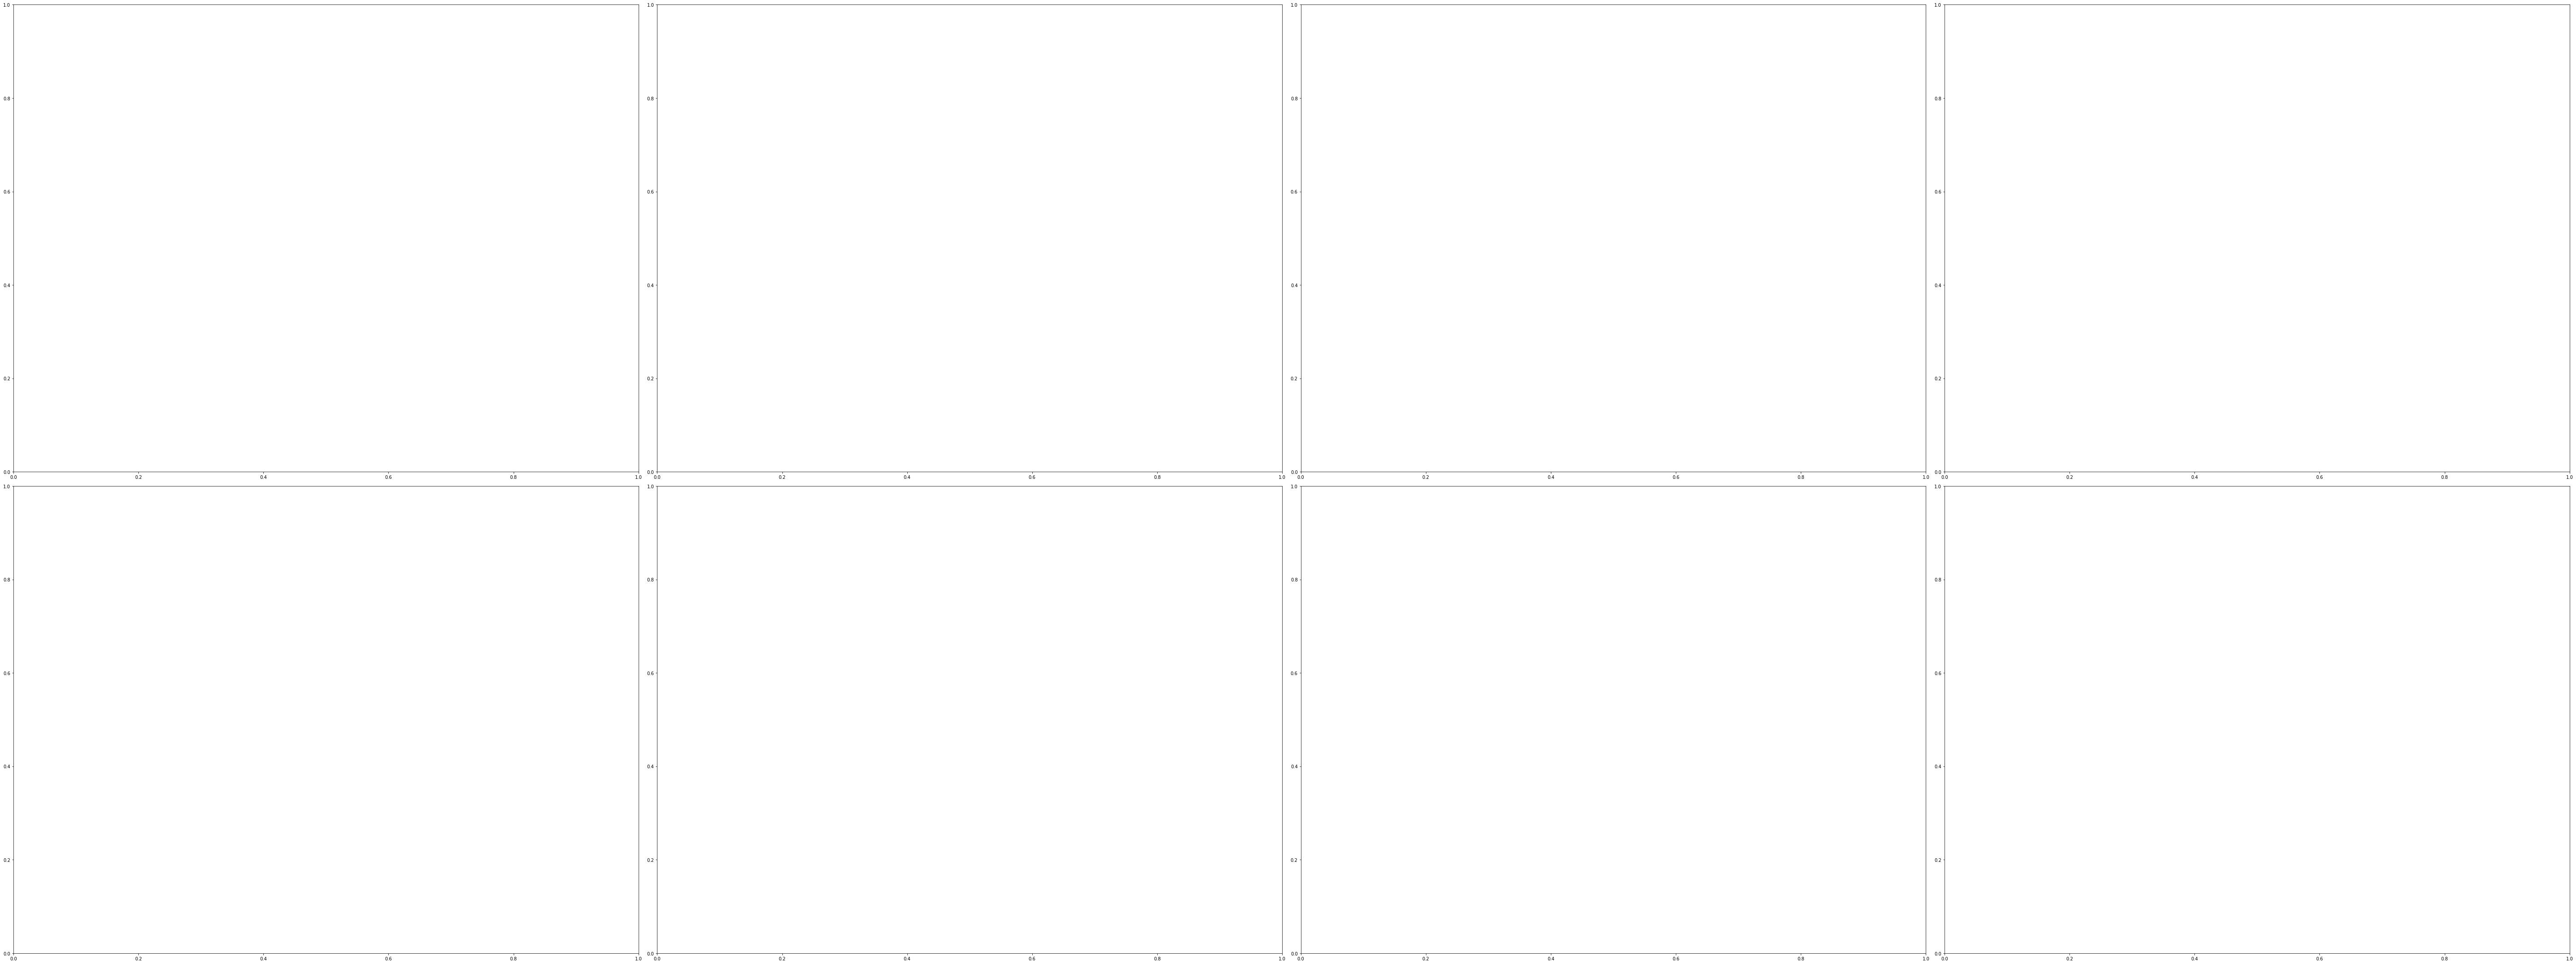

In [28]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'tlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 8 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 9. Deploy! <a class="anchor" id="head-9"></a>

In [49]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_final
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['USER_EXPERIMENT_DIR'],
                         "experiment_dir_final_0_2/resnet18_detector_pruned.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_helmet_pruned_0_2.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final_0_2/resnet18_detector_pruned.etlt \
            -k $KEY

Using TensorFlow backend.
2021-06-20 13:20:09.224378: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 13:20:11.323208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-06-20 13:20:11.323375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 13:20:11.323748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 13:20:11.323765: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 13:20:11.323799: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully o

2021-06-20 13:20:17.284592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-20 13:20:17.284965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2060 SUPER major: 7 minor: 5 memoryClockRate(GHz): 1.68
pciBusID: 0000:06:00.0
2021-06-20 13:20:17.284995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 13:20:17.285022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-06-20 13:20:17.285040: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-06-20 13:20:17.285051: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

In [50]:
print('Exported model:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_final_0_2

Exported model:
------------
total 24M
-rwxrwxrwx 1 1000 1000 24M Jun 20 13:20 resnet18_detector_pruned.etlt


### A. Int8 Optimization <a class="anchor" id="head-9-1"></a>
DetectNet_v2 model supports int8 inference mode in TRT. In order to use int8 mode, we must calibrate the model to run 8-bit inferences. This involves 2 steps

* Generate calibration tensorfile from the training data using tlt-int8-tensorfile
* Use tlt-export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use atleast 10-20% of the training data to calibrate the model. The more data provided during calibration, the closer int8 inferences are to fp32 inferences.*

In [ ]:
!tlt-int8-tensorfile detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                                  -m 40 \
                                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor

In [ ]:
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
            -k $KEY  \
            --cal_data_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor \
            --data_type int8 \
            --batches 20 \
            --batch_size 4 \
            --max_batch_size 4\
            --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt.int8 \
            --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
            --verbose

### B. Generate TensorRT engine <a class="anchor" id="head-9-2"></a>
Verify engine generation using the `tlt-converter` utility included with the docker.

The `tlt-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tlt-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the converter for jetson from the dev zone link [here](https://developer.nvidia.com/tlt-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [52]:
!tlt-converter $USER_EXPERIMENT_DIR/experiment_dir_final_0_2/resnet18_detector_pruned.etlt \
               -k $KEY \
               -c $USER_EXPERIMENT_DIR/experiment_dir_final_0_2/calibration.bin \
               -o output_cov/Sigmoid,output_bbox/BiasAdd \
               -d 3,544,960 \
               -i nchw \
               -m 64 \
               -t fp16 \
               -e $USER_EXPERIMENT_DIR/experiment_dir_final_0_2/resnet18_detector_pruned.trt \
               -b 4

[INFO] Some tactics do not have sufficient workspace memory to run. Increasing workspace size may increase performance, please check verbose output.
[INFO] Detected 1 inputs and 2 output network tensors.


## 10. Verify Deployed Model <a class="anchor" id="head-10"></a>
Verify the exported model by visualizing inferences on TensorRT.
In addition to running inference on a `.tlt` model in [step 8](#head-8), the `tlt-infer` tool is also capable of consuming the converted `TensorRT engine` from [step 9.B](#head-9-2).

*If after int-8 calibration the accuracy of the int-8 inferences seem to degrade, it could be because the there wasn't enough data in the calibration tensorfile used to calibrate thee model or, the training data is not entirely representative of your test images, and the calibration maybe incorrect. Therefore, you may either regenerate the calibration tensorfile with more batches of the training data, and recalibrate the model, or calibrate the model on a few images from the test set. This may be done using `--cal_image_dir` flag in the `tlt-export` tool. For more information, please follow the instructions in the USER GUIDE.

### A. Inference using TensorRT engine <a class="anchor" id="head-10-1"></a>

In [53]:
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt.txt \
                        -o $USER_EXPERIMENT_DIR/etlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/test_images \
                        -k $KEY

Using TensorFlow backend.
2021-06-20 13:31:42.334773: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-06-20 13:31:44,395 [INFO] iva.detectnet_v2.scripts.inference: Overlain images will be saved in the output path.
2021-06-20 13:31:44,395 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer
2021-06-20 13:31:44,834 [INFO] iva.detectnet_v2.inferencer.trt_inferencer: Reading from engine file at: /workspace/mntpt/helmet/detectnet_v2/experiment_dir_final_0_2/resnet18_detector_pruned.trt
[TensorRT] WARNING: Current optimization profile is: 0. Please ensure there are no enqueued operations pending in this context prior to switching profiles
2021-06-20 13:31:45,739 [INFO] iva.detectnet_v2.scripts.inference: Initialized model
2021-06-20 13:31:45,739 [INFO] iva.detectnet_v2.scripts.inference: Commencing inference
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]
2021-0

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

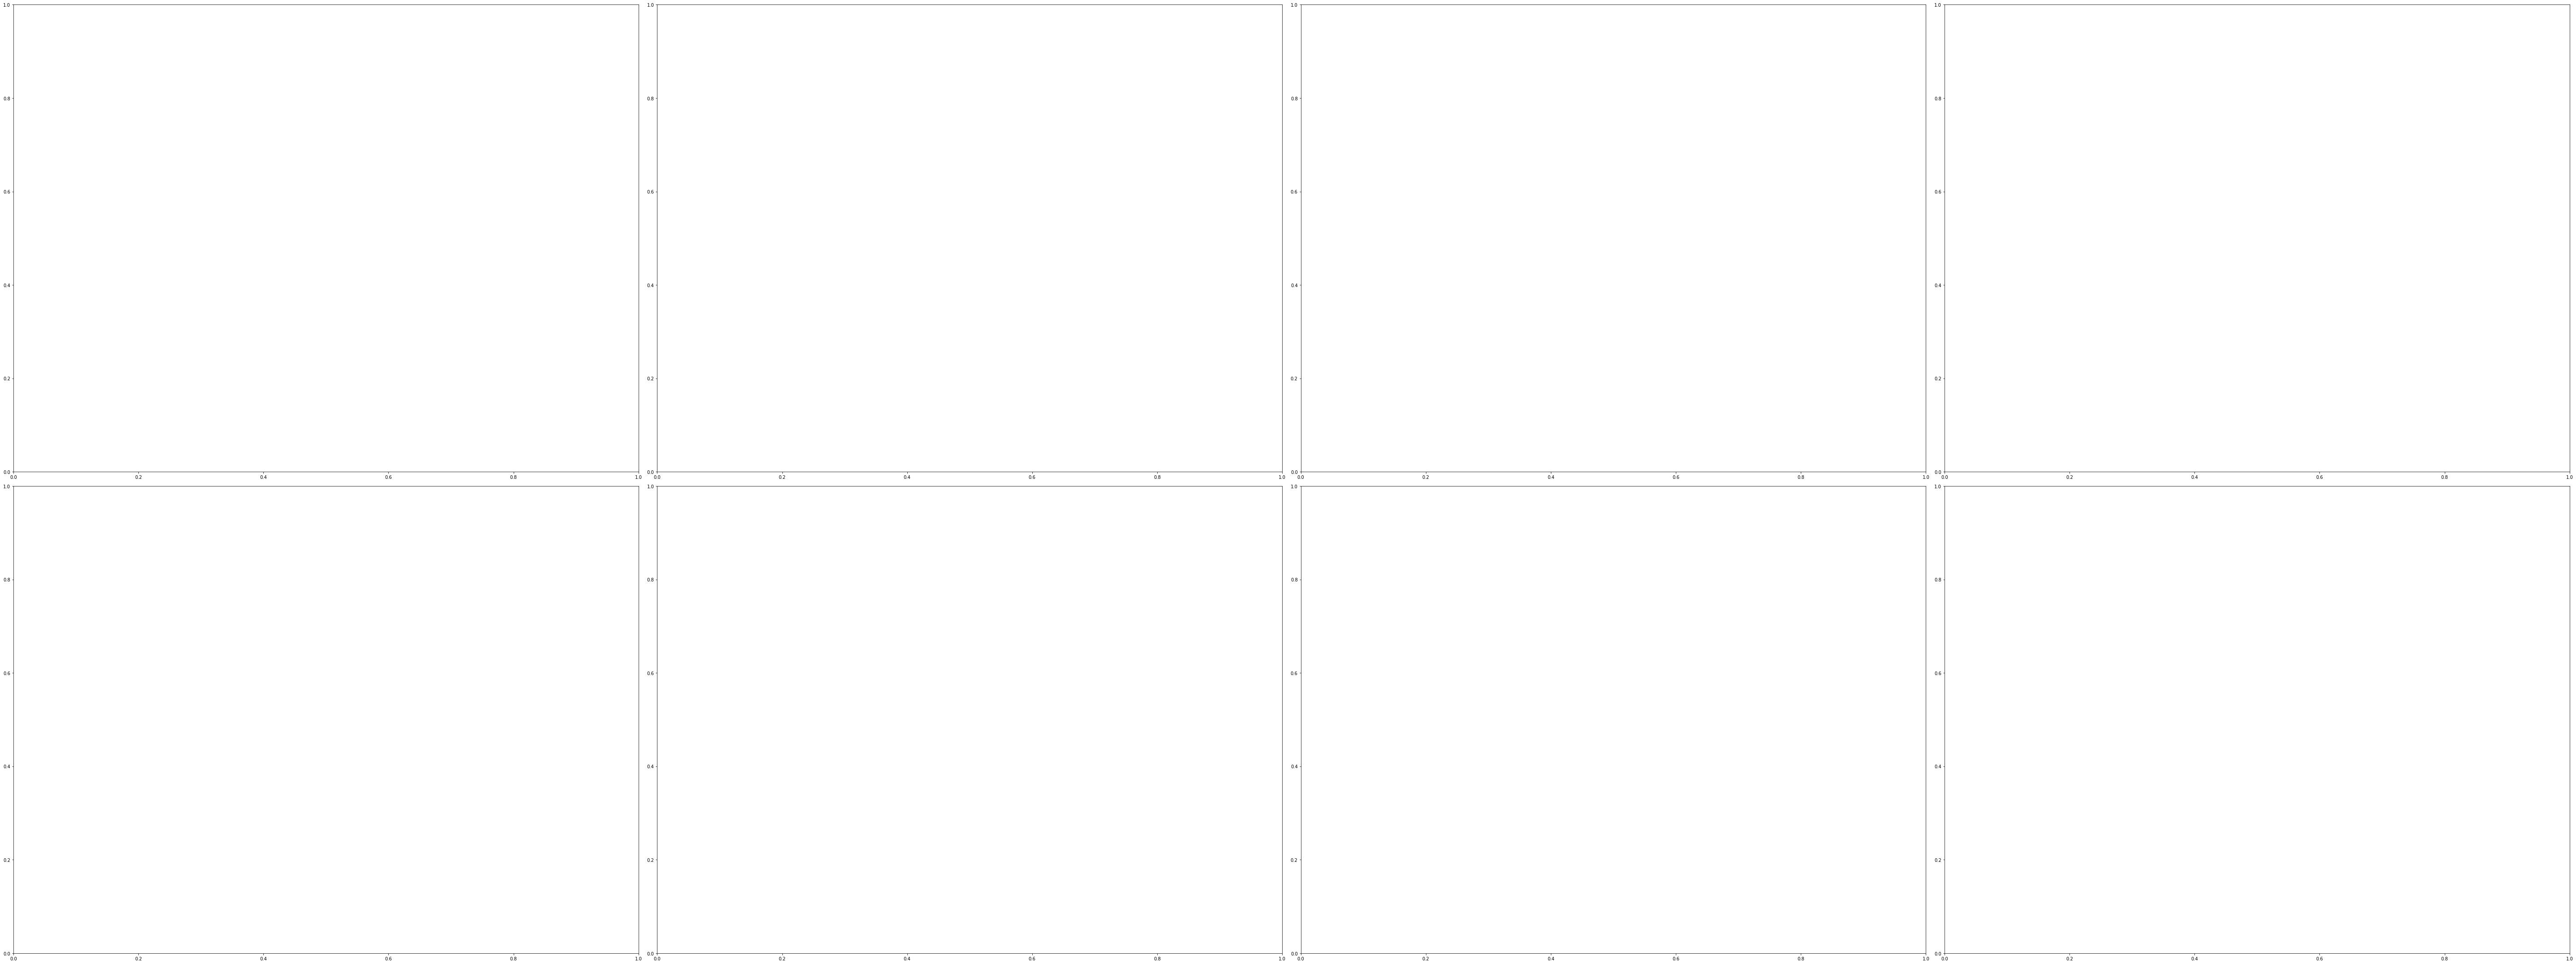

In [40]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'etlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 8 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)